# **Exploration of License Plate Recognition via Machine Learning-based Image Classification Models**
## Yuvraj Puri
### Professor: Stephen Elston
### Semester: Spring 2024



---



#### **Introduction** :

Speed trap cameras have the task of producing recorded images of vehicles that violate speed or traffic violations in areas of construction, school crossings, and general roadways. With that in mind, a moving vehicle does not make for an easy, clear photograph.

One step towards identifying a car is to identify where it came from by using its license plate. By training image classification models, we can identify a car's class (i.e. the state) even if we're left unable to identify the characters that fill the license plate.  



---

####**Project Objective** :
I aim to explore and experiment how differnet image classifiers perform when classifying each of the license plates. To make my dataset more robust and to better simulate more of the difficult, real conditions of image capture of license plates, we will expand our training set with data augmentation. In doing so, we aim to determine how well the models learn from a variety of images and responds to the test data. The project's goals are to implement multiple computer vision strategies to firstly generate many images from a small dataset and secondly to test a range of machine learning algorithms for image classification.

Due to computational constraints, we will limit this testing to two image classification algorithms: a Convolutional Neural Network model and a ResNet152 model.





---

# **Dataset** :

The model will be trained using a dataset anonymously provided on Kaggle of license plates from all 50 states originally used for a classifier for all 50 states and for 5 territories of the United States (Puerto Rico, Guam, the Virgin Islands, American Samoa and the Commonwealth of the Northern Mariana Islands) as well as 1 for Washington D.C. The U.S. territory of Wake Island was not included by the provider of the dataset due to the scarcity of license plates available from the territory.
From the dataset, a selection of original, high quality license plates without augmentation or duplicates was provided such that all the images are size 128 x 224 x 3 in jpg format. All images were cropped such that the license plates occupy at least 90% of the pixels of the image. The data was also partitioned into training and test sets but also provided a file to enable development of original test, validation and training sets.

The test data is partitioned into 56 subdirectories – 1 for each state and 6 for the U.S. territories and Washington D.C. - with 5 test images of license plates per state. The validation data is also partitioned into 56 subdirectories with 5 test images of license plates per state. The training data is partitioned into 56 subdirectories with variable numbers of files per subdirectory, ranging from between 86 images at least to 175 images at most. As mentioned previously, all images in each dataset are in 128 x 224 x 3 in jpg format.

The entire dataset size is 354 MB compressed and when uncompressed it is 363 MB. The dataset utilized specifically (new plates) is about 147 MB and contains a directory structure as shown below. The images are assigned to their subdirectories labeled by state and the images are labeled by number.


# Data Exploration :

In [86]:
!pip install keras_tuner
#!pip install GPUtil
#!pip install augmentor
from keras_tuner import RandomSearch
from tensorflow.keras.layers import LeakyReLU, BatchNormalization


In [29]:
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import numpy
import os
import cv2
import random
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from google.colab import files
from collections import Counter
import io
import pathlib
import tensorflow as tf
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

import PIL
import pathlib
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras import regularizers
import keras
import tensorflow
import Augmentor

from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152
import warnings
warnings.filterwarnings('ignore')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
uploaded = files.upload()

Saving plates.csv to plates.csv


In [10]:
df = pd.read_csv(io.StringIO(uploaded['plates.csv'].decode('utf-8')))
print(df.columns)

Index(['class id', 'filepaths', 'labels', 'data set'], dtype='object')


"plates.csv" is a csv file within "new plates" that contains the data about the entire "new plates" dataset.

The columns within include:


*   "**class id**": refers to the specific class/unique state number the data point belongs to (values range from 0-49) for each of the 50 states of the United States.

*   "**filepaths**": refers to the specific subdirectory within "new plates" that an image can be found (ex. "train/ALABAMA/001.jpg").


*   "**labels**": refers to the specific state an image belongs to and the folder it is a part of (ex. "ALABAMA", "ALASKA", etc.). At minimum, these labels - the states - will be how we evaluate the classifiers.

*   "**data set**": refers to the specific portion of the data an image belongs to (i.e. "train", "test", "valid")


By looking closer at this file, we can get a better idea of how the data in "new plates" is organized or distributed.



In [11]:
def showtot(df):
  """
  input df: dataframe containing our info
  showing first 5 entries, the counts, and dtypes
  """
  display(df.head(5))
  display(df.dtypes)
  print(f'Total: {np.sum(df.Count)}')

def df_uni(series, name):
    """
    Provide univariate variables from series.
    :param series input: series or column from dataframe.
    :param name input: str with name used for graph and univariate analysis

    """
    histo = series
    print(f"Mean number of {name}: {histo.mean()}")
    print(f"Median number of {name}: {histo.median()}")
    print(f"Min number of {name}: {histo.min()}")
    print(f"Max number of {name}: {histo.max()}")

In [12]:
# Make a dataframe containing only the info about training data
train_only = df[df['data set'] == 'train']

train_counts = Counter(train_only['labels'])
state_counts = Counter(df['labels'])
set_counts = Counter(df["data set"])

# Convert the Counter object to a dictionary
train_dict = dict(train_counts)
state_dict = dict(state_counts)
set_dict = dict(set_counts)

# Create a DataFrame from the dictionary
train = pd.DataFrame(list(train_dict.items()), columns=['State', 'Count'])
state = pd.DataFrame(list(state_dict.items()), columns=['State', 'Count'])
dataset = pd.DataFrame(list(set_dict.items()), columns=['Data set', 'Count'])


In [ ]:
showtot(dataset)

,Data set,Count
0,train,8161
1,test,280
2,valid,280


Data set    object
Count        int64
dtype: object

Total: 8721


We can look at the labels and the data set information to get a better idea of how the data is separated.

Our dataset is comprised of a total of 8721 images in .jpg format. Of these, 8161 of them are designated for our training data, and we have 280 images in our test and validation sets.

First, for this entire dataset, the training set is significantly larger than the test and validation sets. In the context of machine learning, this relatively large amount of data can allow for more robust model training and better generalization to unseen data. It also helps mitigate computational load and constraints, especially when mounting, uploading, utilizing the images, and testing any models.


However, the distribution of images across different datasets might result in class imbalance if the classes are not evenly represented within each dataset - as there is 5 images per state in the testing and validation sets. This is not a relative quantity and may result in class imbalance which can lead to biased model predictions and poorer performance on underrepresented classes. Furthermore, the relatively small size of these datasets might limit the ability to evaluate the model's performance accurately.

,State,Count
0,ALABAMA,157
1,ALASKA,149
2,AMERICAN SAMOA,143
3,ARIZONA,139
4,ARKANSAS,169


State    object
Count     int64
dtype: object

Total: 8161

Mean number of state plates: 145.73214285714286
Median number of state plates: 146.0
Min number of state plates: 86
Max number of state plates: 175


Text(0.5, 1.0, 'Bar Graph of State License Plate Counts')

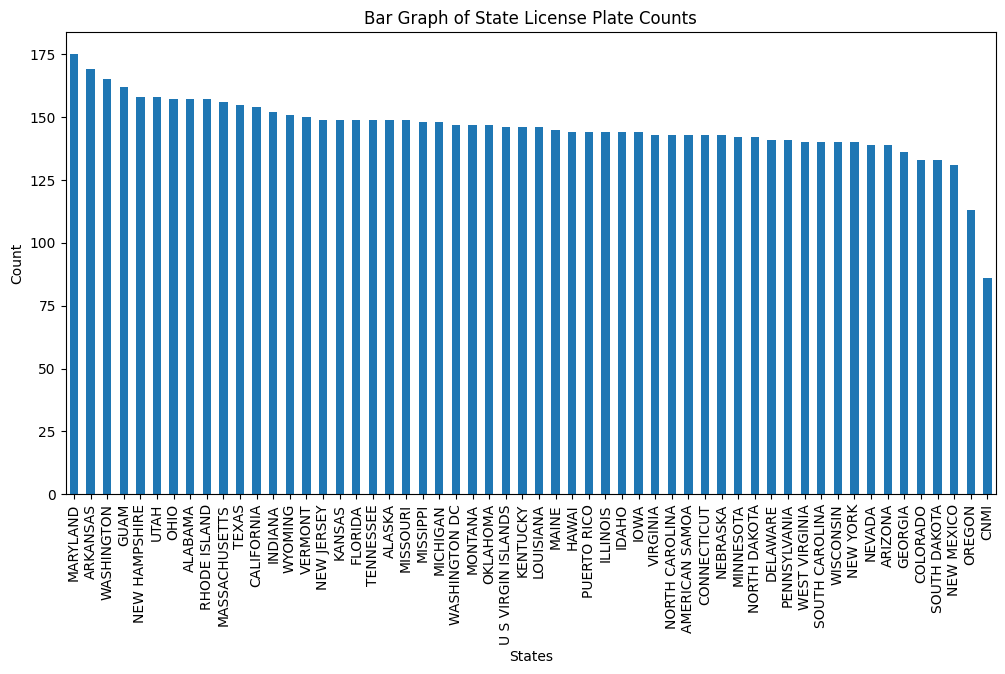

In [13]:
showtot(train)
print()
df_uni(train['Count'], "state plates")

# Showing univariate data on total plates in new plates

# Graphing plates in the dataset (only training set)
plt.figure(figsize=(12, 6))

train_only['labels'].value_counts().plot(kind='bar')
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Bar Graph of State License Plate Counts')
#
#df_bar(df['labels'], "Plates", "states")

There's a great difference between the minimum and maximum plate counts. As reported by the publisher of the dataset, the train set, which makes up the bulk of the data, is not balanced. In the train set in particular, class Maryland contains the most images of 175 files and class CNMI contains the least images with only 86 files.

With a large training set and relatively small test and validation sets, there is a risk of overfitting, where the model learns to memorize the training data rather than generalize well to unseen data. Careful regularization techniques and model evaluation are needed to mitigate this risk.

We will also need to takes steps to add to the images we utilize for the models. For this purpose, we will be adding more images to our training data via data augmentation.

## Specifications
This project is being run on Google Colab with 100 memory units having been purchased.



In [14]:
from psutil import virtual_memory

# contraint tensorflow GPU memory usage, otherwise it will consume all
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


ram_gb = virtual_memory().total / 1e9

if ram_gb < 20:
  print("You are not using a high end run time!")
else:
  print("You are using a high end run time!")


Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized
You are not using a high end run time!


In [16]:

from GPUtil import showUtilization as gpu_usage
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  1% |


# Data

There are 8161 training images, 560 (280 x 2) testing and validation images for a total of 8721 images. As stated previously, this size was selected for ease of utilization yet our dataset size is not necessarily large enough to properly train. In addition, as stated in the description of the dataset, the new plates dataset is a "very high quality dataset" that contains no duplicates, no augmented images, all images have the dimensions (128 X 224 X 3), and all the images have been cropped so the the license plate occupies at least 90% of the pixels in any image.

While this makes it easy for even simple models to achieve high training, validation and test accuracy, more data would serve support finding a more robust algorithm.



---





We will add to the training set via data augmentation. In addition, to improve representation of underrepresented states (e.g. CNMI), we will also utilize oversampling to replicate existing samples all states and especially underrepresented states to balance the dataset. This involves randomly selecting samples from the underrepresented states and duplicating them till we achieve a more balanced dataset. We will copy these images into a new training directory for a total of 200 images per state - a total of 10,000 images for us to classify.



## Pulling up and examples of modifying images

In [18]:
def show_image(image, title='Image'):
    plt.imshow(image)
    plt.title(title)
    plt.show()

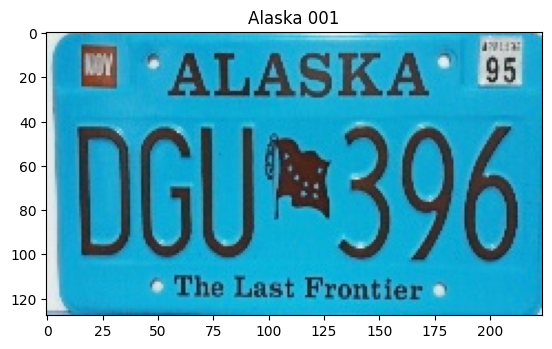

(128, 224, 3)


In [30]:
path = '/content/drive/MyDrive/new plates/train/ALASKA/'
img = cv2.imread(path + "001.jpg")
show_image(img, "Alaska 001")
print(img.shape)

# **Data Augmentation**

In [43]:
# Generate filepaths for the testing and training directories
train_dir = pathlib.Path('/content/drive/MyDrive/new plates/train')
test_dir = pathlib.Path('/content/drive/MyDrive/new plates/test')
valid_dir = pathlib.Path('/content/drive/MyDrive/new plates/valid')

New directory created: '**augment**'

In [24]:
working_directory = pathlib.Path('/content/drive/MyDrive/new plates')
augmented_output_dir = working_directory / 'augment'
augmented_output_dir.mkdir()


In [25]:
# Copy all the training images into the newly created directory
for path in os.listdir(train_dir):
    shutil.copytree((train_dir /path),(augmented_output_dir / path))

Now all the samples in each set has been copied over in the same quantities.

In [26]:
# Numbers of samples in each state.
total=0
labels = os.listdir(augmented_output_dir)
for i in labels:
    directory = augmented_output_dir / i
    classes = pathlib.Path(directory)
    sample_count=len(list(classes.glob('*.jpg')))
    print(f'Directory {i} has {sample_count} samples.')
    total+=sample_count

print(f'Total files copied over: {total} files.')

Directory WYOMING has 151 samples.
Directory UTAH has 158 samples.
Directory TEXAS has 155 samples.
Directory WASHINGTON DC has 147 samples.
Directory U S VIRGIN ISLANDS has 146 samples.
Directory VIRGINIA has 143 samples.
Directory WISCONSIN has 140 samples.
Directory VERMONT has 150 samples.
Directory WEST VIRGINIA has 140 samples.
Directory WASHINGTON has 165 samples.
Directory TENNESSEE has 149 samples.
Directory SOUTH DAKOTA has 133 samples.
Directory SOUTH CAROLINA has 140 samples.
Directory NORTH DAKOTA has 142 samples.
Directory NORTH CAROLINA has 143 samples.
Directory PENNSYLVANIA has 141 samples.
Directory NEW YORK has 140 samples.
Directory OKLAHOMA has 147 samples.
Directory OREGON has 113 samples.
Directory RHODE ISLAND has 157 samples.
Directory OHIO has 157 samples.
Directory PUERTO RICO has 144 samples.
Directory NEW MEXICO has 131 samples.
Directory MONTANA has 147 samples.
Directory NEW HAMPSHIRE has 158 samples.
Directory NEW JERSEY has 149 samples.
Directory MICHIG



---


We have obtained all our training samples in their own subdirectories yet the sample counts are unbalanced. From here, we will utilize the **Augmentor** library for data augmentation.

In [32]:
# We are going to use Augmentor to add more images to our dataset.
# All potential augmentations: random brightness, resize, rotate, skew
# Ideally we would not change the images too much so as to not make the training data
# Too different from what the reality is. Low probability of skew to limit how much the image changes.
# dir: the parent directory of the subdirectory that the label is attached to (i.e. ./augment/)
# subdir: the label of the subdirectory for where the augmented images go (e.g. ALASKA)
# n: value for number of samples of images to take and augment from the directories to take and add to our directories
# default n set to 300.

def bigdata(dir, subdir, n = 300):
  p = Augmentor.Pipeline(source_directory = dir / subdir,
                          output_directory = dir / subdir)
  p.random_brightness(probability=0.7, min_factor=0.7, max_factor=1.3)
  p.resize(probability=0.3, width=64, height=112)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.skew(probability=0.1)

  p.sample(n)

for i in labels:
  bigdata(augmented_output_dir, i)

print("Done!")


Initialised with 151 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/WYOMING.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F82F3C8D930>: 100%|██████████| 300/300 [00:04<00:00, 67.84 Samples/s]


Initialised with 158 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/UTAH.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FC1FFD0>: 100%|██████████| 300/300 [00:03<00:00, 80.34 Samples/s]


Initialised with 155 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/TEXAS.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FCA8430>: 100%|██████████| 300/300 [00:04<00:00, 70.39 Samples/s]


Initialised with 147 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/WASHINGTON DC.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FC1EE60>: 100%|██████████| 300/300 [00:04<00:00, 65.74 Samples/s]


Initialised with 146 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/U S VIRGIN ISLANDS.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FCAA140>: 100%|██████████| 300/300 [00:03<00:00, 79.01 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/VIRGINIA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FC1DD80>: 100%|██████████| 300/300 [00:04<00:00, 73.07 Samples/s]


Initialised with 140 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/WISCONSIN.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FAF3F40>: 100%|██████████| 300/300 [00:04<00:00, 63.51 Samples/s]


Initialised with 150 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/VERMONT.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB43E80>: 100%|██████████| 300/300 [00:03<00:00, 80.52 Samples/s]


Initialised with 140 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/WEST VIRGINIA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB53DF0>: 100%|██████████| 300/300 [00:04<00:00, 73.50 Samples/s]


Initialised with 165 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/WASHINGTON.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB5FCD0>: 100%|██████████| 300/300 [00:04<00:00, 63.35 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/TENNESSEE.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB51960>: 100%|██████████| 300/300 [00:03<00:00, 80.56 Samples/s]


Initialised with 133 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/SOUTH DAKOTA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FAE7DF0>: 100%|██████████| 300/300 [00:04<00:00, 73.75 Samples/s]


Initialised with 140 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/SOUTH CAROLINA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FAF3E80>: 100%|██████████| 300/300 [00:04<00:00, 63.80 Samples/s]


Initialised with 142 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NORTH DAKOTA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB5EFE0>: 100%|██████████| 300/300 [00:03<00:00, 79.23 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NORTH CAROLINA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FAF1AB0>: 100%|██████████| 300/300 [00:03<00:00, 76.19 Samples/s]


Initialised with 141 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/PENNSYLVANIA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FC865F0>: 100%|██████████| 300/300 [00:05<00:00, 58.15 Samples/s]


Initialised with 140 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEW YORK.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FAF2DA0>: 100%|██████████| 300/300 [00:03<00:00, 80.35 Samples/s]


Initialised with 147 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/OKLAHOMA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB5C250>: 100%|██████████| 300/300 [00:04<00:00, 74.54 Samples/s]


Initialised with 113 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/OREGON.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FC1F550>: 100%|██████████| 300/300 [00:05<00:00, 56.57 Samples/s]


Initialised with 157 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/RHODE ISLAND.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB6FEB0>: 100%|██████████| 300/300 [00:05<00:00, 56.24 Samples/s]


Initialised with 157 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/OHIO.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FAF3280>: 100%|██████████| 300/300 [00:04<00:00, 64.45 Samples/s]


Initialised with 144 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/PUERTO RICO.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB6CFA0>: 100%|██████████| 300/300 [00:04<00:00, 70.82 Samples/s]


Initialised with 131 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEW MEXICO.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FAF2E30>: 100%|██████████| 300/300 [00:03<00:00, 78.45 Samples/s]


Initialised with 147 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MONTANA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FAF2D40>: 100%|██████████| 300/300 [00:04<00:00, 61.34 Samples/s]


Initialised with 158 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEW HAMPSHIRE.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FBD3F70>: 100%|██████████| 300/300 [00:04<00:00, 72.56 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEW JERSEY.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB6F3D0>: 100%|██████████| 300/300 [00:04<00:00, 72.32 Samples/s]


Initialised with 148 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MICHIGAN.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FBD2D70>: 100%|██████████| 300/300 [00:04<00:00, 62.47 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MISSOURI.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB6F3D0>: 100%|██████████| 300/300 [00:04<00:00, 73.73 Samples/s]


Initialised with 142 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MINNESOTA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FBD1240>: 100%|██████████| 300/300 [00:03<00:00, 75.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEVADA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FAF3A90>: 100%|██████████| 300/300 [00:09<00:00, 32.82 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/NEBRASKA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FBD0C40>: 100%|██████████| 300/300 [00:06<00:00, 49.91 Samples/s]


Initialised with 148 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MISSIPPI.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB67BB0>: 100%|██████████| 300/300 [00:08<00:00, 34.82 Samples/s]


Initialised with 156 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MASSACHUSETTS.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FBD2770>: 100%|██████████| 300/300 [00:04<00:00, 64.71 Samples/s]


Initialised with 175 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MARYLAND.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB663B0>: 100%|██████████| 300/300 [00:08<00:00, 36.65 Samples/s]


Initialised with 145 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/MAINE.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB6F640>: 100%|██████████| 300/300 [00:06<00:00, 46.08 Samples/s]


Initialised with 146 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/LOUISIANA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB64160>: 100%|██████████| 300/300 [00:08<00:00, 34.42 Samples/s]


Initialised with 144 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/IOWA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB6C040>: 100%|██████████| 300/300 [00:05<00:00, 51.68 Samples/s]


Initialised with 146 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/KENTUCKY.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FA08670>: 100%|██████████| 300/300 [00:07<00:00, 38.97 Samples/s]


Initialised with 136 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/GEORGIA.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x128 at 0x7F826FB8FDF0>: 100%|██████████| 300/300 [00:06<00:00, 49.03 Samples/s]


Initialised with 144 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/IDAHO.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB66F80>: 100%|██████████| 300/300 [00:07<00:00, 39.89 Samples/s]


Initialised with 144 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/HAWAI.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB8EB90>: 100%|██████████| 300/300 [00:08<00:00, 34.79 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/KANSAS.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FB66E00>: 100%|██████████| 300/300 [00:04<00:00, 72.18 Samples/s]


Initialised with 162 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/GUAM.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB8C6A0>: 100%|██████████| 300/300 [00:04<00:00, 70.46 Samples/s]


Initialised with 144 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/ILLINOIS.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FA09D20>: 100%|██████████| 300/300 [00:07<00:00, 41.77 Samples/s]


Initialised with 152 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/INDIANA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB8FE50>: 100%|██████████| 300/300 [00:04<00:00, 71.99 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/FLORIDA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FA08610>: 100%|██████████| 300/300 [00:04<00:00, 72.86 Samples/s]


Initialised with 141 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/DELAWARE.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB52500>: 100%|██████████| 300/300 [00:05<00:00, 58.50 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/CONNECTICUT.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FA0B880>: 100%|██████████| 300/300 [00:03<00:00, 76.29 Samples/s]


Initialised with 133 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/COLORADO.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FCC1D80>: 100%|██████████| 300/300 [00:03<00:00, 77.44 Samples/s]


Initialised with 169 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/ARKANSAS.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FA175B0>: 100%|██████████| 300/300 [00:05<00:00, 58.31 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/ARIZONA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FA12E00>: 100%|██████████| 300/300 [00:03<00:00, 75.98 Samples/s]


Initialised with 143 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/AMERICAN SAMOA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FA08C40>: 100%|██████████| 300/300 [00:04<00:00, 72.55 Samples/s]


Initialised with 149 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/ALASKA.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FCC01F0>: 100%|██████████| 300/300 [00:04<00:00, 60.05 Samples/s]


Initialised with 157 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/ALABAMA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FB5F280>: 100%|██████████| 300/300 [00:04<00:00, 74.24 Samples/s]


Initialised with 86 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/CNMI.

Processing <PIL.Image.Image image mode=RGB size=64x112 at 0x7F826FA11ED0>: 100%|██████████| 300/300 [00:03<00:00, 77.35 Samples/s]


Initialised with 154 image(s) found.
Output directory set to /content/drive/MyDrive/new plates/augment/CALIFORNIA.

Processing <PIL.Image.Image image mode=RGB size=224x128 at 0x7F826FC1E5F0>: 100%|██████████| 300/300 [00:06<00:00, 49.90 Samples/s]

Done!


In [42]:
# Numbers of samples/total images (including augmented) in each after state applying augmentation.
total=0
augmented_labels = os.listdir(augmented_output_dir)
for a in augmented_labels:
    aug_subdir = augmented_output_dir / a
    aug_classdir = pathlib.Path(aug_subdir)
    aug_count = len(list(aug_classdir.glob('*.jpg')))
    print(f'Directory {a} now has {aug_count} samples.')
    total+=aug_count

print(f'New total amount of samples:  {total}.')


Directory WYOMING now has 451 samples.
Directory UTAH now has 458 samples.
Directory TEXAS now has 455 samples.
Directory WASHINGTON DC now has 447 samples.
Directory U S VIRGIN ISLANDS now has 446 samples.
Directory VIRGINIA now has 443 samples.
Directory WISCONSIN now has 440 samples.
Directory VERMONT now has 450 samples.
Directory WEST VIRGINIA now has 440 samples.
Directory WASHINGTON now has 465 samples.
Directory TENNESSEE now has 449 samples.
Directory SOUTH DAKOTA now has 433 samples.
Directory SOUTH CAROLINA now has 440 samples.
Directory NORTH DAKOTA now has 442 samples.
Directory NORTH CAROLINA now has 443 samples.
Directory PENNSYLVANIA now has 441 samples.
Directory NEW YORK now has 440 samples.
Directory OKLAHOMA now has 447 samples.
Directory OREGON now has 413 samples.
Directory RHODE ISLAND now has 457 samples.
Directory OHIO now has 457 samples.
Directory PUERTO RICO now has 444 samples.
Directory NEW MEXICO now has 431 samples.
Directory MONTANA now has 447 samples.

In [38]:
from PIL import Image

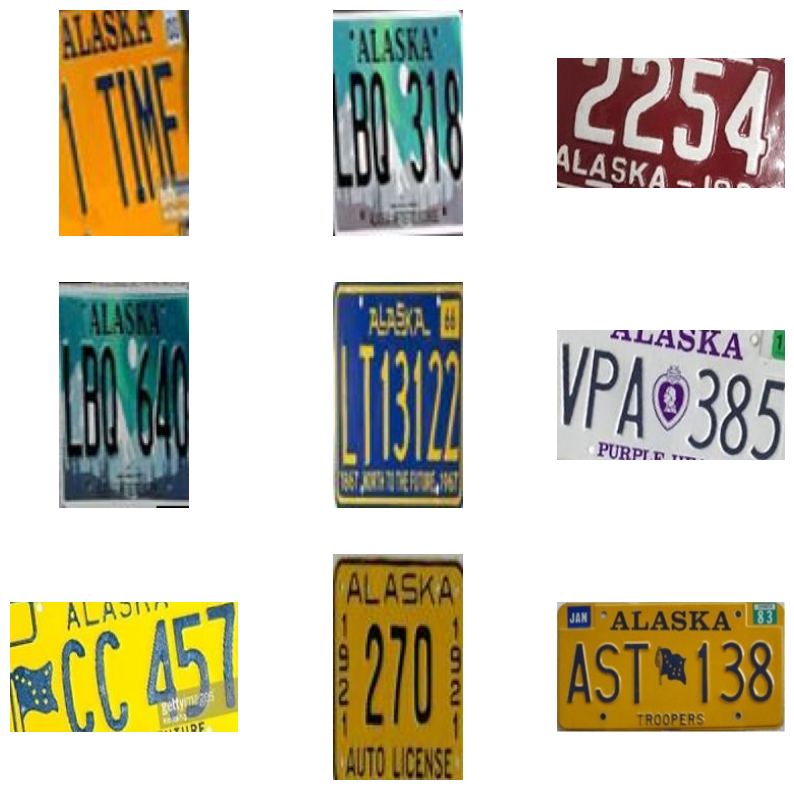

In [41]:
image_paths = []
random_image = pathlib.Path('/content/drive/MyDrive/new plates/augment/ALASKA')
for file in random_image.rglob('*'):
    if file.suffix.lower() in ('.jpg', '.jpeg', '.png'):
        image_paths.append(file)

# Display randomly selected images the selection of newly augmented images
random_image_paths = random.sample(image_paths, 9)
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(random_image_paths):
    plt.subplot(3, 3, i + 1)
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')

plt.show()



As we can see, a lot of the new images have changed a lot, especially in terms of what's in the image is being framed as well as how lit the images are - which should better simulate real life conditions. Though only modified somewhat, the license plates seem much different now from the initial high quality image presented. With further computational capacity, we can how much larger and more different our augmented images can become and thus make our model more robust.


---



## **Image Classification Models**
I will build a convolutional neural network model. I will also create one other models using transfer learning: a pre-trained ResNet152 model and evaluate it against the convolutional neural network.

I will utilize only 1 datasets due to limitations on current computational capacity: I will utilize the newly generated augmented training training set. I will feed them to same three models as shown below.

Because ResNet and EfficientNet will utilize images of dimensions (224 x 224), the images will end up resized that way.


>**Augmented Data**
>> Model 1: CNN Classifier

>> Model 2: pretrained ResNet152





---


## Generate Training and Testing Data

In [44]:

# Loading augmented training set
train_aug = keras.utils.image_dataset_from_directory(
    directory = augmented_output_dir,
    image_size = (224,224),
    label_mode='categorical',
    color_mode='rgb',
    seed = 1,
    batch_size=32)

# Loading validation set
val_data = keras.utils.image_dataset_from_directory(
    directory = valid_dir,
    image_size = (224,224),
    label_mode='categorical',
    color_mode='rgb',
    seed = 1,
    batch_size=32)

# Loading test set
test_data = keras.utils.image_dataset_from_directory(
    directory = test_dir,
    image_size = (224,224),
    label_mode='categorical',
    color_mode='rgb',
    seed = 1,
    batch_size=32)


Found 8161 files belonging to 56 classes.
Found 24961 files belonging to 56 classes.
Found 280 files belonging to 56 classes.
Found 280 files belonging to 56 classes.


## **Original Training Data**


---


### Convolutional Neural Net Image Classifier

In [74]:
nn = Sequential()

# Convolutional layers with LeakyReLU activation and batch normalization
nn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
nn.add(LeakyReLU())
nn.add(MaxPooling2D((2, 2)))
nn.add(BatchNormalization())

nn.add(Conv2D(16, (3, 3), activation='relu'))
nn.add(MaxPooling2D((2, 2)))

nn.add(Conv2D(8, (3, 3), activation='relu'))
nn.add(MaxPooling2D((2, 2)))

nn.add(Dropout(0.2))  # Dropout after convolutional layer

# Flatten layer
nn.add(Flatten())

# Dense layers with dropout
# Dropout after dense layer

nn.add(Dense(112, activation='relu'))
nn.add(Dropout(0.4))  # Dropout after dense layer

# Output layer
nn.add(Dense(56, activation='softmax'))  # Adjust the number of units according to your output classes

# Compile the model
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
nn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_25 (Ba  (None, 111, 111, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 16)      4624      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 54, 54, 16)       

We are utilizing relatively very small parameters due to computational limitations. Speficially, 3 relatively small convolution layers, 3 max pooling layers that will each reduce dimensionality by half, 1 layer of batch normalization, and 2 dropout layers with differing dropout rates and an output based on softmax.

In [75]:
nn.compile(optimizer = 'RMSprop',
           loss = 'categorical_crossentropy',
           metrics = ['accuracy'])

In [76]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor= 'val_accuracy', patience=3, verbose=1),
]

In [77]:
CNN1History = nn.fit(train_aug, epochs=20, validation_data=test_data, callbacks = callbacks)

Epoch 1/20
781/781 [==============================] - 176s 221ms/step - loss: 3.5087 - accuracy: 0.1649 - val_loss: 3.1225 - val_accuracy: 0.3000
Epoch 2/20
781/781 [==============================] - 104s 132ms/step - loss: 2.6031 - accuracy: 0.3705 - val_loss: 2.0734 - val_accuracy: 0.5286
Epoch 3/20
781/781 [==============================] - 101s 128ms/step - loss: 2.1441 - accuracy: 0.4659 - val_loss: 2.0517 - val_accuracy: 0.5357
Epoch 4/20
781/781 [==============================] - 115s 146ms/step - loss: 1.8396 - accuracy: 0.5361 - val_loss: 1.7728 - val_accuracy: 0.5964
Epoch 5/20
781/781 [==============================] - 108s 137ms/step - loss: 1.6407 - accuracy: 0.5802 - val_loss: 2.2016 - val_accuracy: 0.5286
Epoch 6/20
781/781 [==============================] - 94s 120ms/step - loss: 1.4668 - accuracy: 0.6166 - val_loss: 1.7351 - val_accuracy: 0.6143
Epoch 7/20
781/781 [==============================] - 96s 122ms/step - loss: 1.3368 - accuracy: 0.6485 - val_loss: 1.7291 - v



---


## ResNet152

In [87]:
# function to make a ResNet152 model for augmented data

def make_ResNet152_model(hyperparam):
    # Using pretrained weights
    res152 = ResNet152(weights='imagenet', include_top=False)
    for layer in res152.layers:
        layer.trainable = False
    model = Sequential()
    model.add(BatchNormalization(input_shape = (224,224,3)))
    model.add(res152)
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(56, activation='softmax'))
    optimizer = Adam(learning_rate= hyperparam.Choice('learning_rate', values=[1e-2, 5e-3]))

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [88]:
# Make ResNet152 model with parameters specified by keras_tuner's HyperParameters function
make_ResNet152_model(keras_tuner.HyperParameters())


In [89]:
tuner = RandomSearch(
    hypermodel=make_ResNet152_model,
    objective='val_accuracy',
    max_trials=1,
    executions_per_trial=1
)

In [90]:
tuner.search(train_aug, epochs=5, validation_data=val_data,
             steps_per_epoch = len(train_aug)//32)

Trial 1 Complete [00h 02m 45s]
val_accuracy: 0.2142857164144516

Best val_accuracy So Far: 0.2142857164144516
Total elapsed time: 00h 02m 45s


In [91]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 resnet152 (Functional)      (None, None, None, 2048   58370944  
                             )                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 56)                5619768   
                                                                 
Total params: 63990724 (244.11 MB)
Trainable params: 561

In [92]:
# Keep model with best performance
cp_callback = ModelCheckpoint(
    filepath = 'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

# Patience set to 4 due to computational constraints
early_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    mode='max',
    verbose=1
)
# Lowing learning rate as we approach a plateau with a patience of 2 epochs
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=2, verbose=1, mode='max', min_lr=1e-5)


In [93]:
ResNetHistory = best_model.fit(train_aug, epochs=20, validation_data=test_data,callbacks=[cp_callback,early_callback,lr_reduce])


Epoch 1/20
781/781 [==============================] - ETA: 0s - loss: 67.2183 - accuracy: 0.2712
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to best_model.h5
781/781 [==============================] - 422s 526ms/step - loss: 67.2183 - accuracy: 0.2712 - val_loss: 121.2794 - val_accuracy: 0.1429 - lr: 0.0100
Epoch 2/20
781/781 [==============================] - ETA: 0s - loss: 48.9671 - accuracy: 0.4640
Epoch 2: val_accuracy improved from 0.14286 to 0.37857, saving model to best_model.h5
781/781 [==============================] - 410s 519ms/step - loss: 48.9671 - accuracy: 0.4640 - val_loss: 70.9330 - val_accuracy: 0.3786 - lr: 0.0100
Epoch 3/20
780/781 [============================>.] - ETA: 0s - loss: 36.8096 - accuracy: 0.5770
Epoch 3: val_accuracy improved from 0.37857 to 0.44286, saving model to best_model.h5
781/781 [==============================] - 408s 520ms/step - loss: 36.8097 - accuracy: 0.5769 - val_loss: 81.0377 - val_accuracy: 0.4429 - lr: 0.0100
Epo

KeyboardInterrupt: 

## Results

In [78]:
def plot_loss(history):
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']
  x = list(range(1, len(test_loss) + 1))
  plt.plot(x, test_loss, color='red', label='Test loss')
  plt.plot(x, train_loss, color='blue', label='Training loss')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Loss vs. Epoch')
  plt.legend()
  plt.show()
def plot_accuracy(history):
  train_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  x = list(range(1, len(test_acc) + 1))
  plt.plot(x, test_acc, color = 'red', label = 'Test accuracy')
  plt.plot(x, train_acc, label = 'Training accuracy')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Epoch')

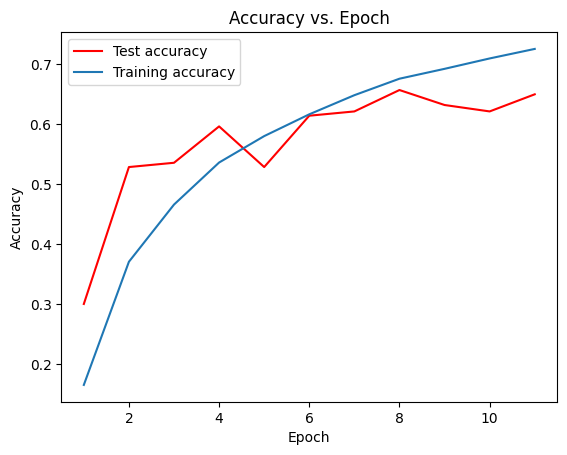

In [79]:
plot_accuracy(CNN1History)

**Highest training accuracy**: 0.7258

**Highest test accuracy**: 0.6571

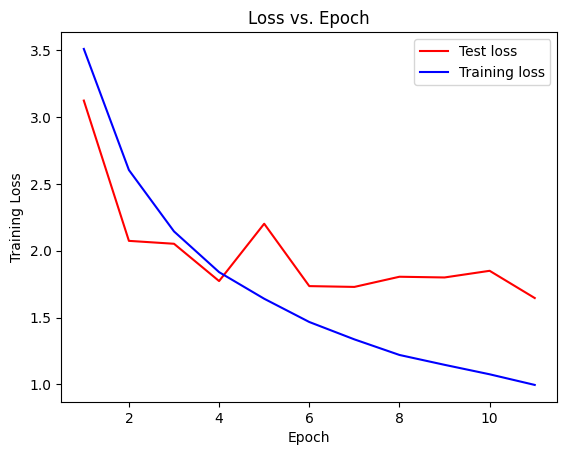

In [81]:
plot_loss(CNN1History)

**Lowest training loss**: 0.9962

**Lowest test loss**: 1.6459

In [94]:
r_acc_t = [0.2712 , 0.4640 ,0.5769 ,0.6502 ]
r_acc_te =[0.1429, 0.3786 , 0.4429 , 0.5071 ]
r_loss_t = [67.2183 , 48.9671 , 36.8097 , 31.4624 ]
r_loss_te = [121.2794 , 70.9330, 81.0377 , 73.0605 ]

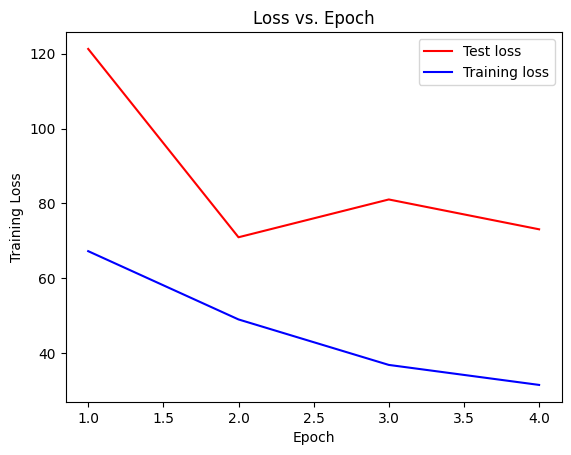

In [95]:

  x = list(range(1, len(r_loss_te) + 1))
  plt.plot(x, r_loss_te, color='red', label='Test loss')
  plt.plot(x, r_loss_t, color='blue', label='Training loss')
  plt.xlabel('Epoch')
  plt.ylabel('Training Loss')
  plt.title('Loss vs. Epoch')
  plt.legend()
  plt.show()

Text(0.5, 1.0, 'Accuracy vs. Epoch')

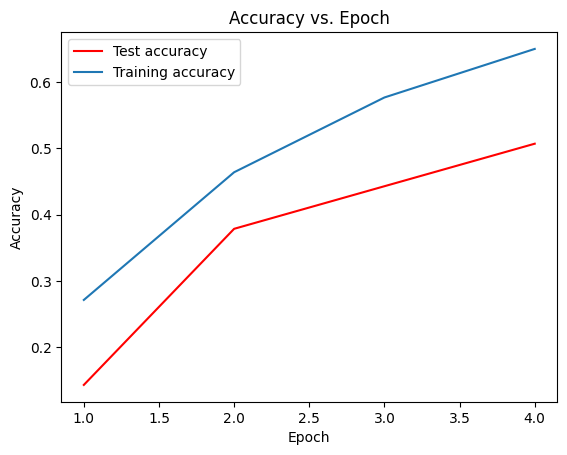

In [97]:
x = list(range(1, len(r_acc_te) + 1))
plt.plot(x, r_acc_te, color = 'red', label = 'Test accuracy')
plt.plot(x, r_acc_t, label = 'Training accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')

## **Observations and Conclusions**


I fit two different models on an augmented dataset as the original dataset was very high quality yet not suitable for training a robust model for image classification. In addition, I utilized a pretrained model that utilized keras_tuner to help fine_tune its parameters. Due to computational limitations, I was not able to utilize the validation dataset provided.

> **CNN**:

>> As we can see from the plot, the CNN model stopped early - 11 epochs out of 20 - due to the early callback monitoring validation accuracy.

>>There's an apparent issue with overfitting for the CNN model. Loss is generally higher than the training loss and test accuracy is generally lower than training accuracy.

>>Given parameters of the Sequential model, it is very likely that the sparse architecture and lack of regularization may have also contributed to it struggling to maintain smooth loss and accuracy curves. In this build, it lacks capacity as a classifier.


>**ResNet152**:

>> Much more computationally intensive. A epoch, comapred to the CNN model, took 3 times as long to run.

>> Had to stop the epochs early due to unavoidable contraints.

>> Loss was higher due to having a different loss function. With that said, we were operating on validation accuracy with both models and thus far, ResNet had shown no signs of plateauing nor any instances of spiking downward with training or test accuracy. Test loss was variable during this with a spike in the second epoch.

**Important to note:**


1.   These conclusions are only representative of the observations made in this instance of testing.
2.   Due to increasing execution time, computational and temporal constraints, we made the choice to make several limitations. These include, but are not limited to, hyperparameter choices for ResNet152, scale of neural network architecture for the CNN, added additional trials for tuning the hyperparameters, using only 2 models (ideally, we would've also compared it to EfficientNetB0), and not fully running the ResNet152 function.

3.   Epochs: Above results indicates that early stopping callback stops evaluation under 20 Epochs. Due to computation limitation and increasing exeuction time, I used patience of 3 epochs for CNN and 4 epochs for the ResNet model while outright stopping the ResNet model early. I believe, more epochs would allow convergence of train and test accuracy, specifically for the ResNet model.




